## Basic Concepts : Nodes, Edges & State

- Explore Nodes, Edges & State
- Vizualize LangGraph
- Comparing LCEL and Langraph
- Conditional Edges
- Reducer Function


#### Nodes

➡ A node is just a function or step that does something in your LangGraph.

**Example:** generate_text(), search_database()

### Edges
➡ An edge is the connection from one node to another.
It tells the graph which node runs next.

**Example:** edge(from=generate_text, to=summarize)

#### State
➡ State is a shared data object that moves through the graph.
Every node can read and update it.

**Example:** state["answer"] = "Hello World"



#### Eg:
**User**  -> Find me the cheapest flight to Goa

**Agent 1** -> Search Flight

**Agent 2** -> Compares Cost and check timings

**Agent 3** -> Summarizes the result

In [ ]:
!pip install langgraph

In [5]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int

def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input

graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

# graph.add_edge(START, "branch_a")
graph.set_entry_point("branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

runnable = graph.compile()

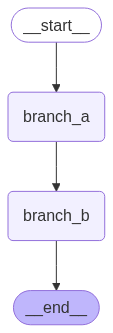

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [7]:
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [8]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current value: {'string_value': 'a', 'numeric_value': 1}


{'string_value': 'a', 'numeric_value': 1}

In [13]:
def modify_state(input: InputState):
    input['string_value'] = 'a'
    input['numeric_value'] += 1
    print(input)

    return input

In [14]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [15]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'a', 'numeric_value': 2}
{'string_value': 'a', 'numeric_value': 3}


{'string_value': 'a', 'numeric_value': 3}

In [16]:
from langchain_core.runnables import RunnableLambda


runnable = RunnableLambda(modify_state)

chain = runnable | runnable

chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'a', 'numeric_value': 2}
{'string_value': 'a', 'numeric_value': 3}


{'string_value': 'a', 'numeric_value': 3}

In [20]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    print(input)
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.set_entry_point("branch_a")
graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")

graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

runnable = graph.compile()

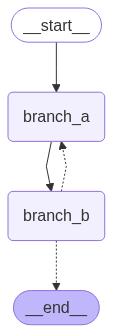

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aa', 'numeric_value': 2}
{'string_value': 'aaa', 'numeric_value': 3}
{'string_value': 'aaaa', 'numeric_value': 4}
{'string_value': 'aaaaa', 'numeric_value': 5}


{'string_value': 'aaaaa', 'numeric_value': 5}

In [23]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add

In [24]:
class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]

In [25]:
def modify_state(input: InputState):
    return input

In [27]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [28]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}